In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import cv2
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from torchvision.transforms import v2
import random
import torch
# Set seeds for reproducibility
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
file_img = '/kaggle/input/platesv2/plates.zip'
file_out = '/kaggle/working'

import zipfile
# Open the ZIP file
with zipfile.ZipFile(file_img, 'r') as zip_ref:
    # Extract all contents to a directory
    zip_ref.extractall(file_out)
print("ZIP file extracted successfully!")

ZIP file extracted successfully!


In [41]:
train_file = '/kaggle/working/plates/train'
test_file = '/kaggle/working/plates/test'


clean_file = '/kaggle/working/plates/train/cleaned'
wo_clean = '/kaggle/input/plates-without-bg/plates/train/cleaned'
dirty_file = '/kaggle/working/plates/train/dirty'
wo_dirty = '/kaggle/input/plates-without-bg/plates/train/dirty'

test_file = '/kaggle/working/plates/test'
train_folder = [clean_file,dirty_file,test_file,wo_clean,wo_dirty]

full_img = []

for each in train_folder:
    tmp_img = []
    for dirname, _, filenames in os.walk(each):
        for filename in filenames:
            #print(filename)
            #print(os.path.join(dirname, filename))
            if filename != '.DS_Store':
                tmp_img.append(os.path.join(dirname, filename))
        full_img.append(tmp_img)

train_cleaned_names = full_img[0]+full_img[3]
train_dirty_names = full_img[1]+full_img[4]
test_img_name = full_img[2]


In [42]:
print('the images as cleaned in the train are: ',len(train_cleaned_names))
print('the images as dirty in the train are: ',len(train_dirty_names))
print('the images the test are: ',len(test_img_name))


print('image size in train:',cv2.imread(train_cleaned_names[0]).shape)
print('image size in train:',cv2.imread(train_cleaned_names[2]).shape)


the images as cleaned in the train are:  40
the images as dirty in the train are:  40
the images the test are:  744
image size in train: (341, 256, 3)
image size in train: (256, 342, 3)


In [43]:
train = train_cleaned_names + train_dirty_names
print(len(train))
x = train
y = [1]*len(train_cleaned_names)+ [0]*len(train_dirty_names)

80


In [44]:
import os
from sklearn.model_selection import train_test_split

x = train_cleaned_names + train_dirty_names
y = [1]*len(train_cleaned_names) + [0]*len(train_dirty_names)

x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.2,random_state = 42)

print(len(x_train))
print(len(x_val))
print(len(y_train))
print(len(y_val))
test = test_img_name
print(len(test))

64
16
64
16
744


In [45]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

class PlateDataset(Dataset):
    def __init__ (self,link,label=None,transform = None):
        self.link = link
        self.label = label
        self.transform = transform

    def __len__(self):
        return len(self.link)

    def __getitem__(self,idx):
        each_link = self.link[idx]
        #each_label = self.label[idx] if self.label is not None else None
        imaj = cv2.imread(each_link)
        imaj = cv2.resize(imaj,(224,224))
        color_imaj = cv2.cvtColor(imaj,cv2.COLOR_BGR2RGB)


        if self.transform: #Apply transform
            #print(tensor.shape) #120,120,3
            tensor = torch.from_numpy(color_imaj).permute(2, 0, 1).float()/255 #normalize it here
            #If the input tensor is already torch.float32, scale=True in compose doesn’t perform scaling because it assumes the data is already scaled
            transformed = self.transform(tensor)
            tensor = transformed
            
        if self.label is not None:
            each_label = self.label[idx]
            return tensor, torch.tensor(each_label)
        else:
            #print(type(tensor))
            return tensor
            

In [46]:
class MeanSTDCalculator():
    def __init__(self,inputs):
        self.input = inputs
       

    def calculation(self):
        avg_mean = [] #[b,g,r]
        avg_std = []  #[b,g,r]
        
        num_img = len(self.input)

        m_b, s_b = 0.0, 0.0
        m_g, s_g = 0.0, 0.0
        m_r, s_r = 0.0, 0.0


        for each in self.input:
            #print(each)
            image = cv2.imread(each)
            image = cv2.resize(image,(224,224))
            image = image.astype(np.float32)/255
            b,g,r = cv2.split(image)

            # Accumulate sums for mean
            m_b += np.mean(b)
            m_g += np.mean(g)
            m_r += np.mean(r)
    
            # Accumulate sums for std
            s_b += np.std(b)
            s_g += np.std(g)
            s_r += np.std(r)

        # Final mean and std values across all images
        m_b /= num_img
        m_g /= num_img
        m_r /= num_img

        s_b /= num_img
        s_g /= num_img
        s_r /= num_img


        return np.round([m_b, m_g, m_r], 2).tolist(), np.round([s_b, s_g, s_r], 2).tolist()

std_mean = MeanSTDCalculator(x)
train_mean , train_std = std_mean.calculation()

std_mean = MeanSTDCalculator(test)
test_mean,test_std = std_mean.calculation()

In [47]:
train_mean,train_std

([0.34, 0.35, 0.38], [0.24, 0.25, 0.25])

In [48]:
test_mean,test_std

([0.44, 0.44, 0.44], [0.18, 0.17, 0.17])

In [49]:
train_mean, train_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


train_transforms = [
    v2.Compose([
        v2.CenterCrop((180, 180)),  # More balanced than (20,200)
        v2.Resize((224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation(degrees=(-15, 15), fill=0),  # Less extreme rotation
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        v2.Normalize(mean=train_mean, std=train_std)
    ]),
    v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), scale=(0.85, 1.0), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.3),
        v2.RandomGrayscale(p=0.2),
        v2.Normalize(mean=train_mean, std=train_std)
    ]),
    v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
        v2.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        v2.Normalize(mean=train_mean, std=train_std)
    ]),
    v2.Compose([
        v2.CenterCrop((180, 180)),  # Keeping center-focused augmentation
        v2.Resize((224, 224), antialias=True),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
        v2.Normalize(mean=train_mean, std=train_std)
    ]),
    v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), scale=(0.85, 1.0), antialias=True),
        v2.RandomErasing(p=0.3, scale=(0.05, 0.15), ratio=(0.5, 2.0), value=train_mean),  # More natural erasing
        v2.Normalize(mean=train_mean, std=train_std)
    ]),

    v2.Compose([
        v2.RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0), antialias=True),
        v2.RandomHorizontalFlip(p=0.7),
        v2.RandomVerticalFlip(p=0.7),
        v2.RandomRotation(degrees=(-45, 45), fill=0),
        v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        v2.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=15),
        v2.RandomPerspective(distortion_scale=0.15, p=0.5),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        v2.Normalize(mean=train_mean, std=train_std)
    ])
]


val_transforms = v2.Compose([
    v2.CenterCrop((180, 180)),  # Fixed crop for consistency
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),  
    v2.Normalize(mean=train_mean, std=train_mean)
])

test_transforms = v2.Compose([
    v2.CenterCrop((180, 180)),  # Crop around plate area
    v2.Resize((224, 224)),  # Zoom in to make it more visible
    v2.Normalize(mean=train_mean, std=train_mean)  # Keep normalization    
])


In [50]:
train_dataset = PlateDataset(x_train,y_train,transform =random.choice(train_transforms)) #random.choice(train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size= 8,shuffle = True,drop_last=False,num_workers=2) # to get the left overs

val_dataset = PlateDataset(x_val,y_val,transform = val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size= 8,drop_last=False,num_workers=0)

In [56]:
torch.cuda.device_count()

0

In [57]:
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

patience = 2
patient = 0
best_score = float('inf')

def early_stopping(score):
    global patient, best_score  # Use global to keep values across calls

    if score< best_score:
        best_score = score
        patient =0
    else:
        patient += 1 

    return patient > patience
        

def cnn_model_operation(model,x,y,num_epoch,lr,device = None):

    if device is None:  # Use existing device if provided
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x_train,x_val,y_train,y_val = train_test_split(x,y,test_size = 0.25,random_state = 42)

    # before getting start the training:
    train_transform = random.choice(train_transforms)
    train_dataset = PlateDataset(x_train,y_train,transform = train_transform) #random.choice(train_transforms)
    train_dataloader = DataLoader(train_dataset, batch_size= 8,shuffle = True,drop_last=False,num_workers = torch.cuda.device_count()) # to get the left overs

    val_dataset = PlateDataset(x_val,y_val,transform = val_transforms)
    val_dataloader = DataLoader(val_dataset, batch_size= 8,drop_last=False,num_workers = torch.cuda.device_count())


    #adjust the model as i like
    for param in model.parameters():
        param.requires_grad = False
    #for name, param in model.named_parameters():
    #    print(name,param.requires_grad)
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True

    #add FC layer
    model.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),

    nn.Linear(256,128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.5),

    nn.Linear(128,1),
    #nn.Sigmoid() loss function needs to get raw value
    )
    
    num_epoch = num_epoch
    total_train_counter = 0

    criterion = nn.BCEWithLogitsLoss()
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)#move the model to device after unfreezing/freezing stuff
    
    for epoch in range(num_epoch):
        total_train_loss = 0 
        total_train_acc = 0
        train_counter = 0
        iteration = 0
        model.train() #mode: train
        for image,label in train_dataloader:

            iteration +=1 #count how many iter will be done in this loop 
            num_of_data = label.shape[0]
            train_counter +=num_of_data #accumulate how many data passing through

            #print(label.shape) #torch.Size([8])
            image = image.float()
            label = label.float()
            image = image.to(device)
            label = label.to(device)
    
            optimizer.zero_grad() #clear gradients
            outputs = model(image) 
            outputs=outputs.view(-1)
            #print(outputs.shape) torch.Size([8, 1])
            #print(outputs.view(-1).shape) torch.Size([8])
        
            loss = criterion(outputs,label)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() #accumulate loss
            #outputs = torch.sigmoid(outputs)
            probs = torch.sigmoid(outputs)
            preds = (probs>0.5).view(-1).float()
            total_train_acc += (preds==label).sum().item()
            #print(train_counter) #8 -- 16 -- 24 -- 28
        

        print(f"Epoch{epoch+1}: train accuracy: {total_train_acc/train_counter:.2f}%, train loss: {total_train_loss/iteration:.2f}%")
        
        total_val_acc = 0
        total_val_loss = 0
        val_counter =0
        
        model.eval()
        with torch.no_grad():
            iteration = 0
            for image,label in val_dataloader:
                iteration +=1
                #print(label.shape) #torch.Size([8])
                num_of_data = image.shape[0]
                val_counter+= num_of_data
                
                image = image.float()
                label = label.float()
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                output = output.view(-1)
                probs = torch.sigmoid(output)
                preds = (probs>0.5).view(-1).float()

                val_loss = criterion(output,label)
                total_val_loss += val_loss.item() #accumulate loss
                total_val_acc += (preds==label).sum().item()
    
        print(f"Epoch{epoch+1}: val accuracy: {total_val_acc/val_counter:.2f}%, val loss: {total_val_loss/iteration:.2f}%")
        print('---------------------------------------------------------------------------')
        if early_stopping(total_val_loss/iteration):
            print("Early stopping triggered!")
            break  # ✅ **Breaks the main training loop**
    return model

In [53]:
if torch.cuda.is_available():
    print('gpu')
    print('device name:',torch.cuda.get_device_name(0))
else:
    print('cpu')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cpu


In [54]:
#test

def test_evaluation_export(test,model,excelname):
    
    test_dataset = PlateDataset(test,transform = test_transforms)
    test_dataloader = DataLoader(test_dataset, batch_size= 8,shuffle = False,drop_last=False)
    
    model.eval()

    total_res = []

    with torch.no_grad():
        for image in test_dataloader:
             #print(label.shape) #torch.Size([8])
            image = image.float()
            image = image.to(device)

            output = myresnet18(image)
            output = output.view(-1)
            thresholded_outputs  = (output > 0.5).float()
            a=thresholded_outputs.tolist()
            total_res.extend(a)

    res = []
    for e in total_res:
        if int(e) == 1:
            res.append('cleaned')
        else:
            res.append('dirty')


    ids = []
    for each in test_img_name:
        #print(each)
        name = os.path.basename(each).split('.')[0]
        ids.append(name)
    

    mydict = {'id':ids,
             'label':res}
    mydata = pd.DataFrame(mydict)
    mydata['id'] = mydata['id']
    filename = f"result_{excelname}.csv"
    mydata.to_csv(filename, index=False, float_format='%04d')  # Adds leading zeros when saving

In [59]:
# it is with imagenet mean and std value

from torchsummary import summary

model_18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_18.to(device)
#summary(model_18,input_size = (3,224,224),batch_size= 8)

patience = 5
patient = 0
best_score = float('inf')

num_epoch = 30
myresnet18 = cnn_model_operation(model_18,x,y,num_epoch,lr=0.0005,device=device)
test_evaluation_export(test,myresnet18,'resnet18W4O')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch1: train accuracy: 0.47%, train loss: 0.77%
Epoch1: val accuracy: 0.60%, val loss: 0.67%
---------------------------------------------------------------------------
Epoch2: train accuracy: 0.72%, train loss: 0.56%
Epoch2: val accuracy: 0.85%, val loss: 0.58%
---------------------------------------------------------------------------
Epoch3: train accuracy: 0.73%, train loss: 0.57%
Epoch3: val accuracy: 0.90%, val loss: 0.39%
---------------------------------------------------------------------------
Epoch4: train accuracy: 0.85%, train loss: 0.36%
Epoch4: val accuracy: 0.90%, val loss: 0.33%
---------------------------------------------------------------------------
Epoch5: train accuracy: 0.80%, train loss: 0.42%
Epoch5: val accuracy: 0.90%, val loss: 0.28%
---------------------------------------------------------------------------
Epoch6: train accuracy: 0.88%, train loss: 0.40%
Epoch6: val accuracy: 0.95%, val loss: 0.23%
--------------------------------------------------------

In [ ]:
'''from torchsummary import summary

model_18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model_18.to(device)
#summary(model_18,input_size = (3,224,224),batch_size= 8)

patience = 2
patient = 0
best_score = float('inf')

num_epoch = 30
myresnet18 = cnn_model_operation(model_18,x,y,num_epoch,lr=0.0005,device=device)
test_evaluation_export(test,myresnet18,'resnet18_v3')
'''

In [ ]:
#with imagenet mean and std value

model_34 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
model_34.to(device)
#summary(model_18,input_size = (3,224,224),batch_size= 8)

patience = 2
patient = 0
best_score = float('inf')

num_epoch = 30
myresnet34 = cnn_model_operation(model_34,x,y,num_epoch,lr=0.0005,device=device)
#test_evaluation_export(test,myresnet34,'resnet34')

## Review the outputs:

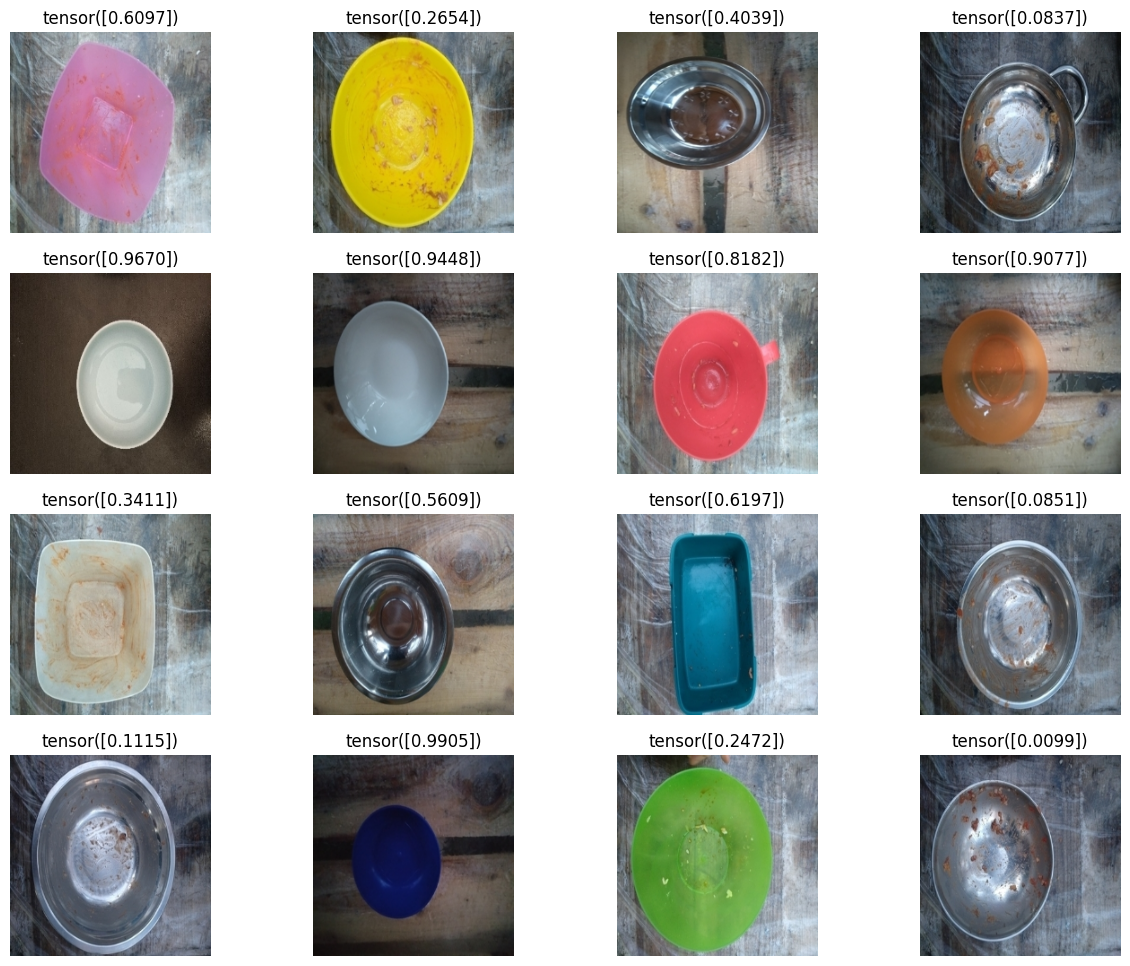

In [60]:
fig, ax = plt.subplots(4,4,figsize = (15,12))
tmodel = myresnet18

test_data = random.sample(test, 16)  # Select 16 random elements

for i in range(4):
    for j in range(4):
        idex = i*4+j
        data = test_data[idex]
        imaj = cv2.imread(data)
        imaj = cv2.resize(imaj,(224,224))
        imaj = cv2.cvtColor(imaj,cv2.COLOR_BGR2RGB)
        torch_imaj = torch.from_numpy(imaj).permute(2,0,1).float()/255
        torch_imaj=torch_imaj.unsqueeze(0)
        torch_imaj=torch_imaj.to(device)
       

        tmodel.eval()
        with torch.no_grad():
            output = tmodel(torch_imaj)
            output = output.view(-1)
            probs = torch.sigmoid(output)
            #print(output)
            ax[i][j].imshow(imaj)
            ax[i][j].set_title(probs)
            ax[i][j].axis('off')

